#### IMPORTS

In [1]:
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from math import exp

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

from cvxopt import matrix as cvxopt_matrix, solvers as cvxopt_solvers

#### PARAMETER

In [2]:
parameter = 'class'
files = ["chips", "geyser"]

kf = KFold(n_splits=5)
cvxopt_solvers.options['show_progress'] = False

kernels = [("linear", ["No params"]), ("poly", [2, 3, 4, 5]), ("gauss", [x for x in np.linspace(1, 5, 10)])]
coefficients = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]

#### DATA

In [3]:
def get_data(name: str):
    data = pd.read_csv('data/%s.csv' % name).sample(frac=1)
    data_x = np.array(data.drop([parameter], axis=1))
    data_y = np.array(data[parameter].apply(lambda y: 1 if y == 'P' else -1))
    return np.array([[data_x[i], data_y[i]] for i in range(len(data))])

#### SVM

In [4]:
class SVM:
    def __init__(self, kernel='linear', C=1.0, param=0, epsilon=1e-2):
        self.C = C
        self.param = param
        self.epsilon = epsilon
        self.kernels = {
            'linear': lambda x1, x2: x1 @ x2,
            'poly': lambda x1, x2: np.sum([(x * y) ** self.param for (x, y) in zip(x1, x2)]),
            'gauss': lambda x1, x2: exp(-self.param * np.sum([(x - y) ** 2 for (x, y) in zip(x1, x2)])),
        }
        self.kernel = self.kernels[kernel]

    def fit(self, X, y):
        m, _ = X.shape
        H = np.array([[self.kernel(x1, x2) for x2 in X] for x1 in X]) * 1.

        P = cvxopt_matrix(np.outer(y, y) * H)
        q = cvxopt_matrix(-np.ones((m, 1)))
        G = cvxopt_matrix(np.vstack((np.eye(m) * -1, np.eye(m))))
        h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * self.C)))
        A = cvxopt_matrix(y.reshape(1, -1) * 1.)
        b = cvxopt_matrix(np.zeros(1))

        solution = cvxopt_solvers.qp(P, q, G, h, A, b)
        alpha = np.ravel(solution['x'])

        filtering = alpha > self.epsilon
        indexes = np.arange(len(alpha))[filtering]
        a = alpha[filtering]
        ys = y[filtering]
        b = np.sum([(ys[i] - np.sum(a * ys * H[indexes[i], filtering])) for i in range(len(a))]) / len(a)

        return X, y, alpha, b

    def predict(self, X, y, x, alpha, b):
        calc = lambda point: np.sum([alpha[i] * y[i] * self.kernel(X[i], point) for i in range(len(X))]) + b
        return np.array([np.sign(calc(point)) for point in x])

In [5]:
def solve_svm(data: np.ndarray, kernel: str, C: float, param: float):
    max_score = 0
    best_result = ()

    model = SVM(kernel=kernel, C=C, param=param)
    for train_index, test_index in kf.split(data):
        train_data, test_data = data[train_index], data[test_index]
        x_train, y_train = np.stack(train_data[:, 0], axis=0), np.stack(train_data[:, 1])
        x_test, y_test = np.stack(test_data[:, 0], axis=0), np.stack(test_data[:, 1])

        current_result = model.fit(x_train, y_train)
        prediction = model.predict(x_test, y_train, x_test, *current_result[2:])
        current_score = accuracy_score(y_test, prediction)
        if current_score > max_score:
            max_score = current_score
            best_result = current_result

    return max_score, best_result

#### DRAW

In [6]:
def test(data: np.ndarray, kernel: str, C: float, param: float, best_params):
    X, y, alpha, b = best_params
    _x, _y = np.stack(data[:, 0], axis=0), np.stack(data[:, 1], axis=0)
    model = SVM(kernel=kernel, C=C, param=param)
    prediction = model.predict(X, y, _x, alpha, b)
    score = accuracy_score(_y, prediction)

    bg_x = np.array([x for x in it.product(np.linspace(min(X[:, 0]), max(X[:, 0]), 50),
                                           np.linspace(min(X[:, 1]), max(X[:, 1]), 50))])
    bg_y = model.predict(X, y, bg_x, alpha, b)

    plt.scatter(X[y >= 0][:, 0], X[y >= 0][:, 1], marker='+', color='green')
    plt.scatter(X[y < 0][:, 0], X[y < 0][:, 1], marker='_', color='red')
    plt.scatter(bg_x[bg_y >= 0][:, 0], bg_x[bg_y >= 0][:, 1], marker='.', color='green', alpha=0.3)
    plt.scatter(bg_x[bg_y < 0][:, 0], bg_x[bg_y < 0][:, 1], marker='.', color='red', alpha=0.3)
    plt.show()

    return score

C:\Temp\ipykernel_4992\2581822490.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[data_x[i], data_y[i]] for i in range(len(data))])


In progress... ||||||||

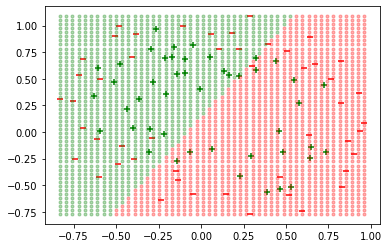


 File = chips Best params:  linear 0.05 No params Score = 0.5338983051
In progress... ||||||||||||||||||||||||||||||||

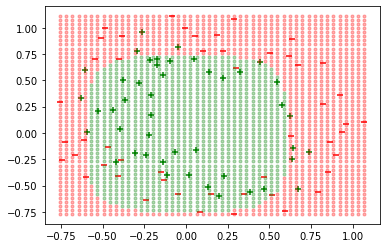


 File = chips Best params:  poly 50.0 4 Score = 0.7796610169
In progress... ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

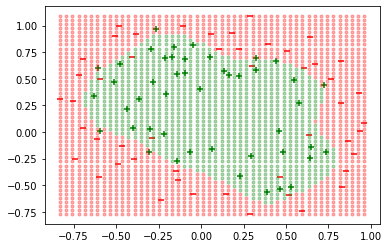


 File = chips Best params:  gauss 50.0 4.111111111111111 Score = 0.8305084746
In progress... 

C:\Temp\ipykernel_4992\2581822490.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[data_x[i], data_y[i]] for i in range(len(data))])


||||||||

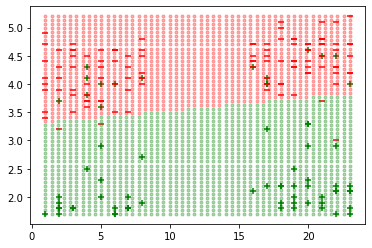


 File = geyser Best params:  linear 0.1 No params Score = 0.8963963964
In progress... ||||||||||||||||||||||||||||||||

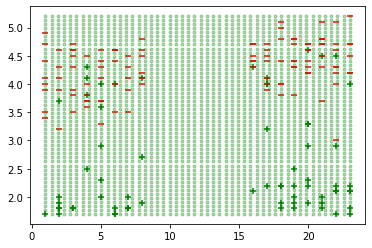


 File = geyser Best params:  poly 0.5 5 Score = 0.3963963964
In progress... ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

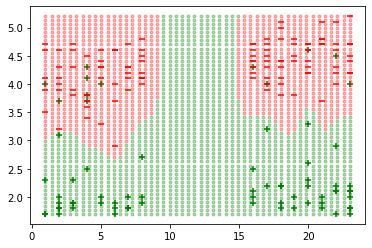


 File = geyser Best params:  gauss 0.5 1.4444444444444444 Score = 0.9099099099


In [7]:
def main():
    for file in files:
        data = get_data(file)
        for (kernel, params) in kernels:
            best_score = 0
            best_params = ()
            best_result = ()
            print("In progress...", end=" ")
            for C in coefficients:
                for param in params:
                    current_score, current_result = solve_svm(data, kernel=kernel, C=C, param=param)
                    print("|", end="")
                    if current_score > best_score:
                        best_score = current_score
                        best_result = current_result
                        best_params = (kernel, C, param)

            score = test(data, *best_params, best_result)
            print("\n File = %s" % file, "Best params: ", *best_params, "Score = %.10f" % score)


main()